In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("../..")

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import utils.constants as constants

In [4]:
df = pd.read_csv("resources/data/raw/loan.csv")

/tmp/ipykernel_61492/2311671977.py:1: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("resources/data/raw/loan.csv")


### Drop unwanted columns

In [8]:
colummns_to_drop = (
    constants.CONSTANT_COLUMNS + 
    constants.NULL_COLUMNS + 
    constants.HIGH_CARDINALITY_COLUMNS +
    constants.NOT_ALLOWED_COLUMNS +
    constants.DESCRIPTION_COLUMNS
)
df = df.drop(columns=colummns_to_drop)
df.shape

(887379, 45)

### Preprocess target

In [9]:
df = df.loc[
    (df[constants.TARGET_COLUMN] == constants.FULLY_PAID_STATUS) |
    (df[constants.TARGET_COLUMN] == constants.CHARGED_OFF_STATUS)
]
df[constants.TARGET_COLUMN] = df[constants.TARGET_COLUMN].map({
    constants.FULLY_PAID_STATUS: 0,
    constants.CHARGED_OFF_STATUS: 1
})

In [23]:
df["emp_title"] = df["emp_title"].str.strip()

In [24]:
means = df.groupby("emp_title").agg({"loan_status": "mean"})

In [25]:
means_to_impute = {title: mean.values[0] for title, mean in means.iterrows()}

In [30]:
df["emp_title"].map(means_to_impute).fillna(0.17)

0         0.170000
1         0.200000
2         0.170000
3         0.000000
5         0.000000
            ...   
887351    0.262048
887364    0.000000
887366    0.178571
887369    0.200000
887371    0.170000
Name: emp_title, Length: 252971, dtype: float64

### Identify missing values

In [43]:
missing_cols_idx = (
    df.isna().any(axis=0).values.tolist()
)
cols_with_nulls = df.columns.values[missing_cols_idx]
df[cols_with_nulls].isna().mean()

emp_title                      0.055070
emp_length                     0.039123
mths_since_last_delinq         0.556665
mths_since_last_record         0.875092
revol_util                     0.000787
last_pymnt_d                   0.002083
last_credit_pull_d             0.000083
collections_12_mths_ex_med     0.000221
mths_since_last_major_derog    0.812054
tot_coll_amt                   0.251839
tot_cur_bal                    0.251839
total_rev_hi_lim               0.251839
dtype: float64

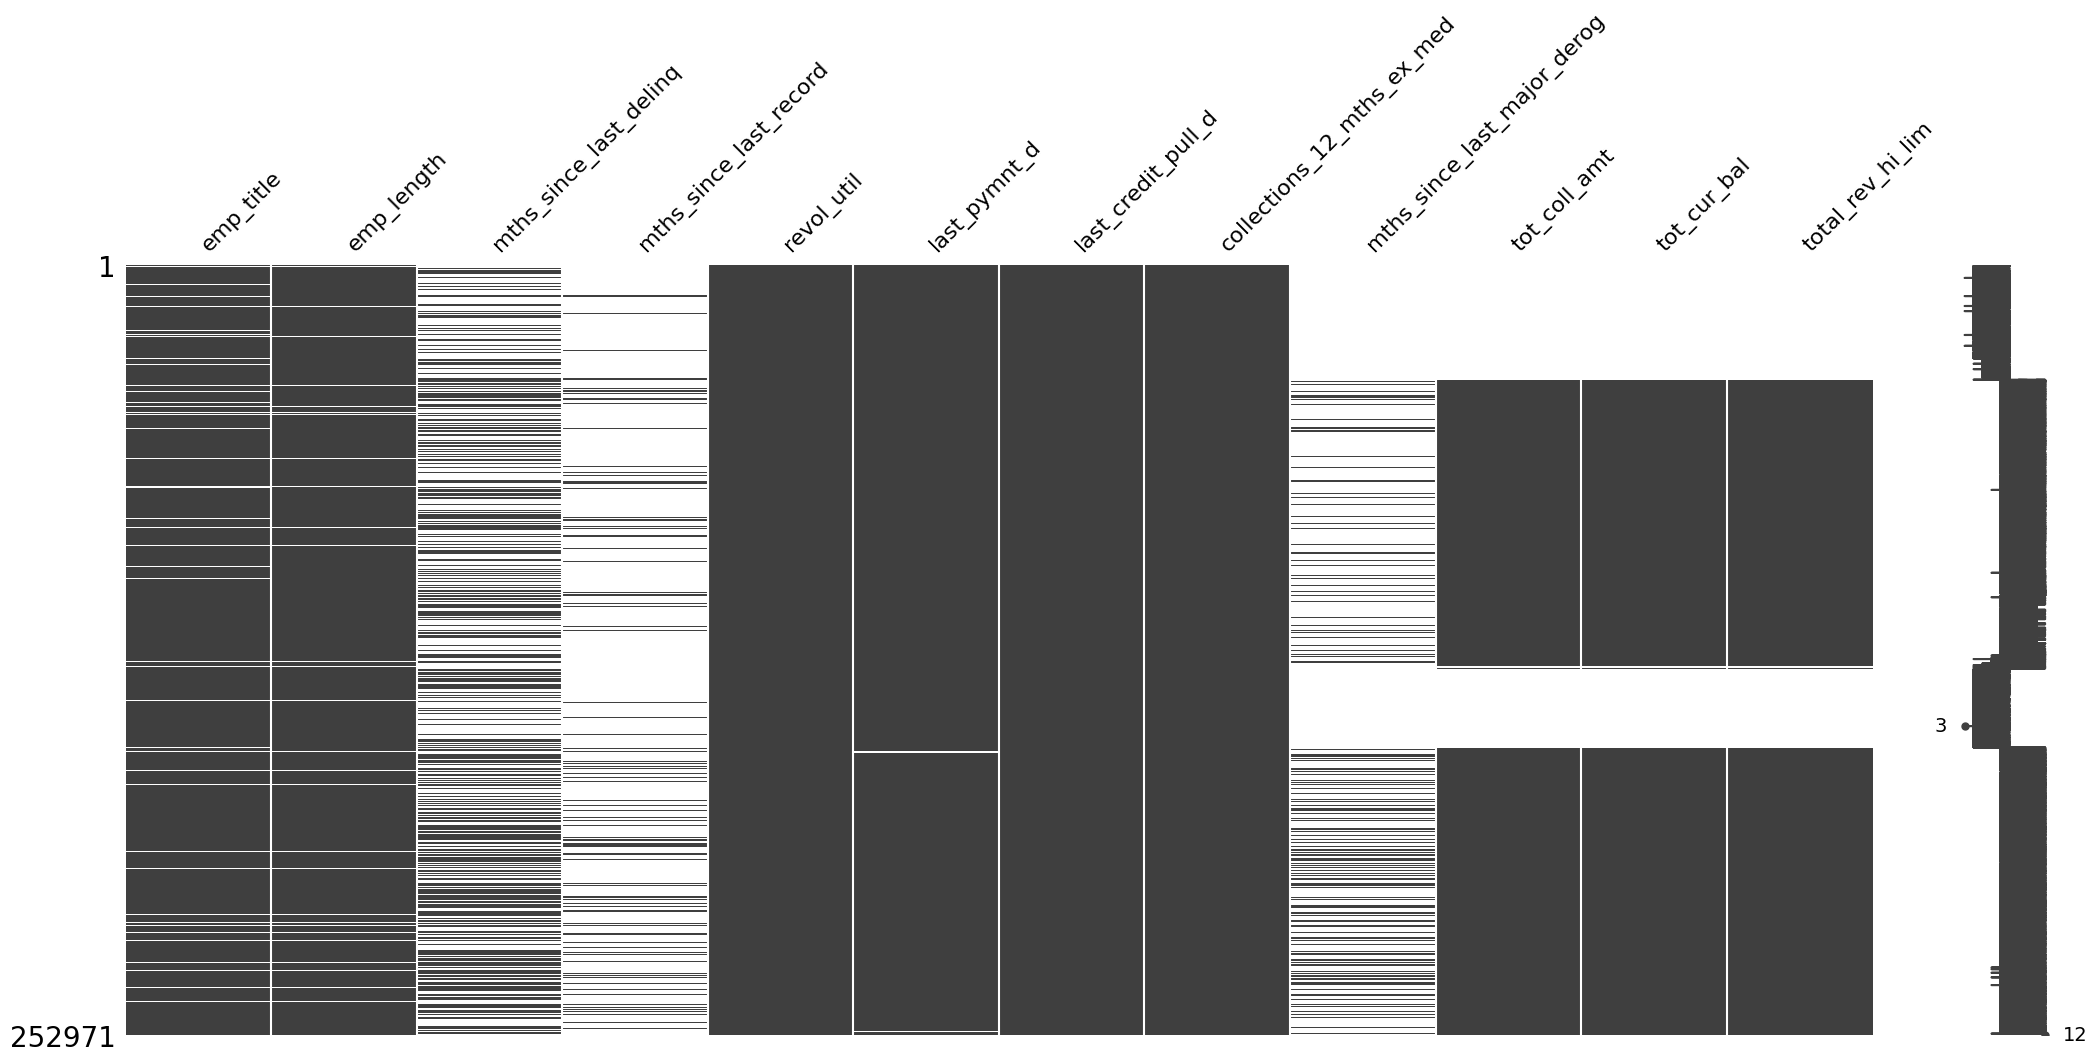

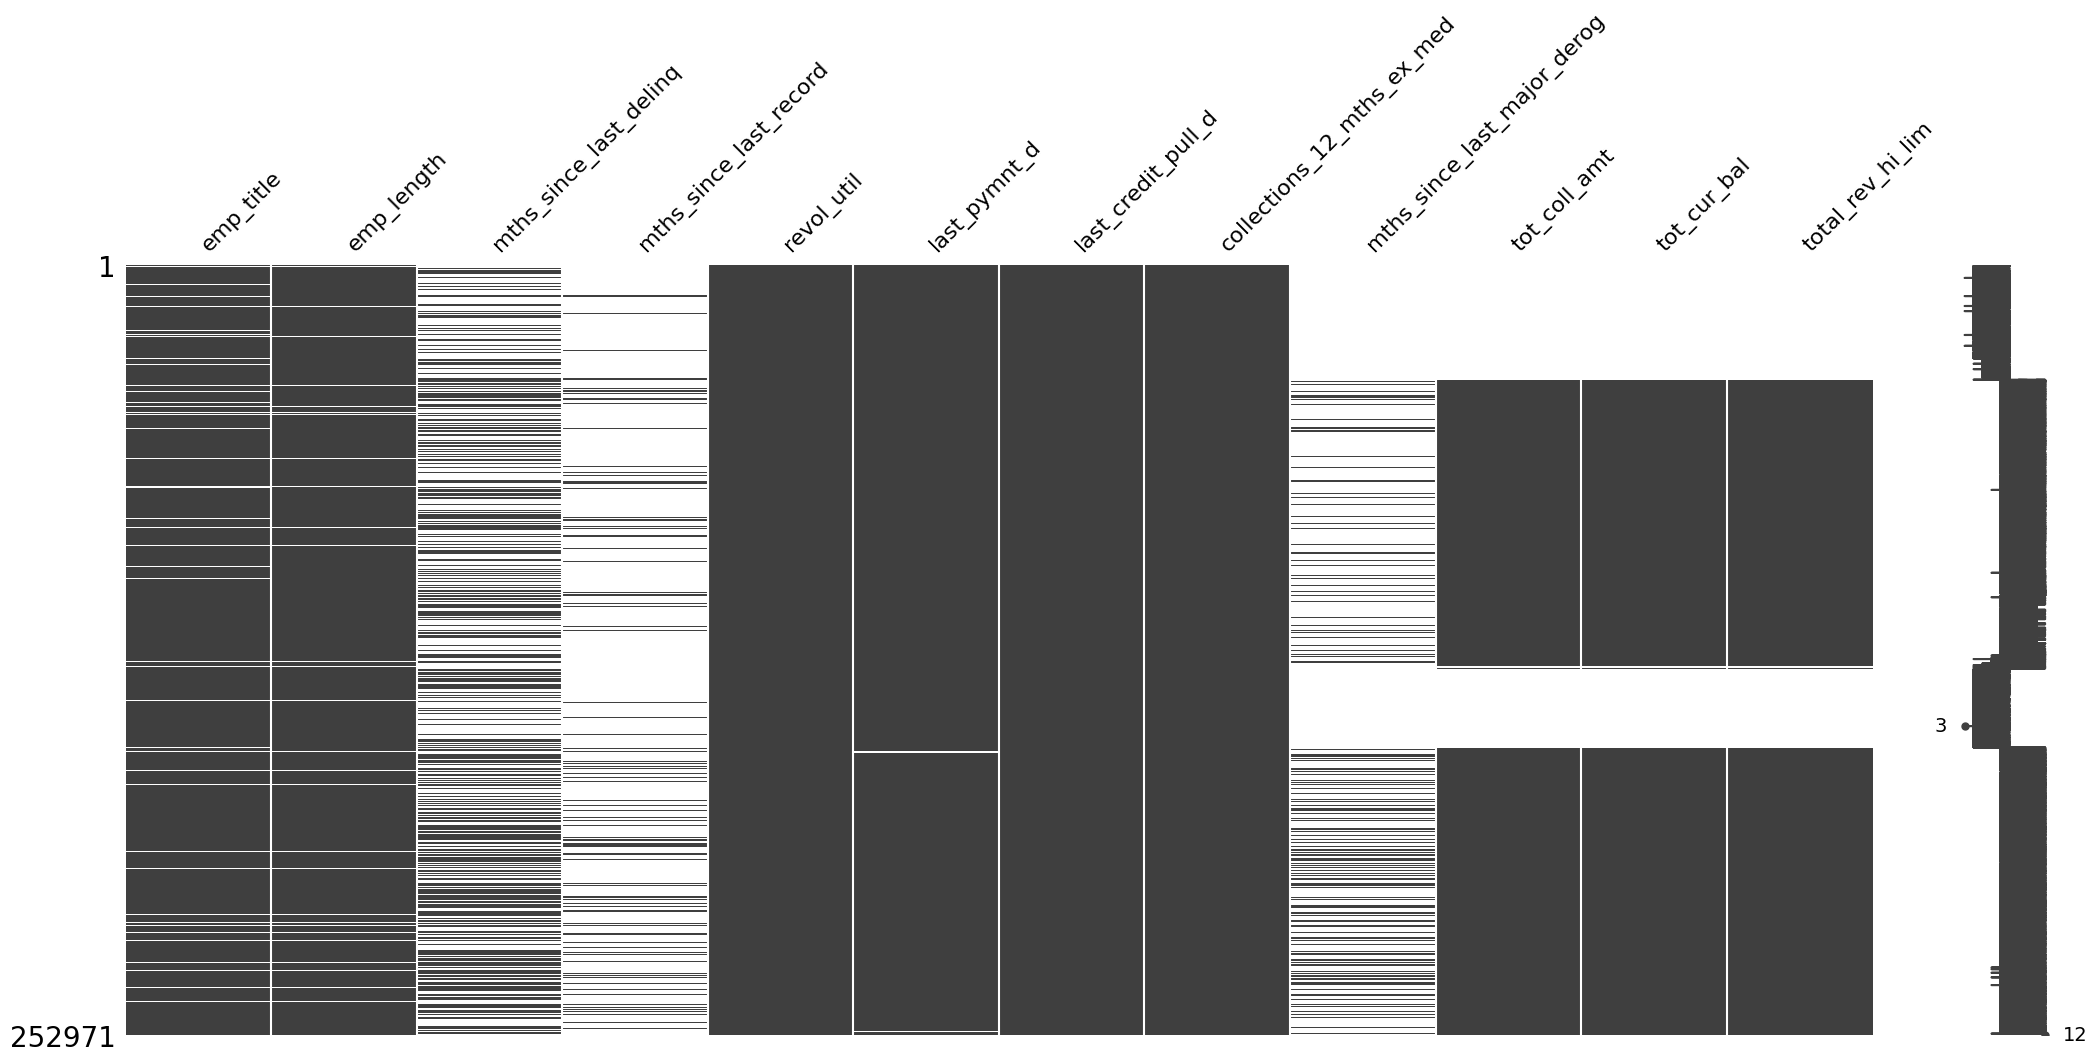

In [47]:
msno.matrix(df[cols_with_nulls])
plt.show()

In [52]:
df[cols_with_nulls.tolist()]

,emp_title,emp_length,mths_since_last_delinq,mths_since_last_record,revol_util,last_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,NaN,10+ years,NaN,NaN,83.7,Jan-2015,Jan-2016,0.0,NaN,NaN,NaN,NaN
1,Ryder,< 1 year,NaN,NaN,9.4,Apr-2013,Sep-2013,0.0,NaN,NaN,NaN,NaN
2,NaN,10+ years,NaN,NaN,98.5,Jun-2014,Jan-2016,0.0,NaN,NaN,NaN,NaN
3,AIR RESOURCES BOARD,10+ years,35.0,NaN,21.0,Jan-2015,Jan-2015,0.0,NaN,NaN,NaN,NaN
5,Veolia Transportaton,3 years,NaN,NaN,28.3,Jan-2015,Sep-2015,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
887351,supervisor,10+ years,38.0,NaN,63.4,Aug-2015,Jan-2016,0.0,38.0,0.0,207975.0,20400.0
887364,Coordinator of RSVP,< 1 year,16.0,NaN,25.8,Jul-2015,Jun-2015,0.0,28.0,0.0,24696.0,41700.0
887366,Painter,2 years,NaN,NaN,97.6,Dec-2015,Dec-2015,0.0,NaN,0.0,8357.0,1800.0
887369,Lead Custodian,10+ years,NaN,84.0,5.6,Jun-2015,Nov-2015,0.0,NaN,0.0,18979.0,30100.0


I propose following imputation methods:
* `emp_title` -> separate category
* `emp_length` -> separate category
* `mths_since_last_delinq` -> categorization + separate category
* `mths_since_last_record` -> categorization + separate category
* `revol_util` -> mice
* `last_pymnt_d` -> mice
* `last_credit_pull_d` -> mice
* `collections_12_mths_ex_med` -> 0
* `mths_since_last_major_derog` -> categorization + separate category
* `total_rev_hi_lim` -> mice
* `tot_coll_amt` -> 0
* `tot_cur_bal` -> 0

In [58]:
cols_to_impute = [
    "emp_title", 
    "emp_length", 
    "mths_since_last_delinq", 
    "mths_since_last_record",
    "revol_util",
    "last_pymnt_d",
    "last_credit_pull_d",
    "collections_12_mths_ex_med", 
    "mths_since_last_major_derog", 
    "total_rev_hi_lim", 
    "tot_coll_amt", 
    "tot_cur_bal"
]

In [2]:
# Proof that these are only imputation columns
df.drop(columns=cols_to_impute).isna().sum().sum()

NameError: name 'df' is not defined